In [ ]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 353
Receiving objects: 100% (526/526), 28.62 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=7584b21730dc70ab31bfc4bd12740be4ff70abcd493dca172ceab455640d09f5
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v1.16.1


In [ ]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="HuggingFace_TextGeneration")

wandb: Currently logged in as: abdussamad. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/notebooks/wandb/run-20230920_100241-4tz6x2r0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run chocolate-firebrand-2
wandb: ⭐️ View project at https://wandb.ai/abdussamad/HuggingFace_TextGeneration
wandb: 🚀 View run at https://wandb.ai/abdussamad/HuggingFace_TextGeneration/runs/4tz6x2r0


# Text Generation

## Greedy Search Decoding

In [ ]:
import pandas as pd

# hide_output
def greedy_search_decoding(tokenizer, model):
    input_txt = "Transformers are the"
    input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
    iterations = []
    n_steps = 8
    choices_per_step = 5

    with torch.no_grad():
        for _ in range(n_steps):
            iteration = dict()
            iteration["Input"] = tokenizer.decode(input_ids[0])
            output = model(input_ids=input_ids)
            # Select logits of the first batch and the last token and apply softmax
            next_token_logits = output.logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)
            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
            # Store tokens with highest probabilities
            for choice_idx in range(choices_per_step):
                token_id = sorted_ids[choice_idx]
                token_prob = next_token_probs[token_id].cpu().numpy()
                token_choice = (
                    f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
                )
                iteration[f"Choice {choice_idx+1}"] = token_choice
            # Append predicted next token to input
            input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
            iterations.append(iteration)

    return pd.DataFrame(iterations)

###GPT-2 -- Medium

Loading GPT-2 Medium Model

In [ ]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# GPT2-XL is Model
model_name_medium = "gpt2-medium"
tokenizer_medium = AutoTokenizer.from_pretrained(model_name_medium)
model_medium = AutoModelForCausalLM.from_pretrained(model_name_medium).to(device)

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
itr = greedy_search_decoding(tokenizer_medium, model_medium)
pd.DataFrame(itr)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.37%),only (3.35%),best (2.75%),first (2.54%),ultimate (2.20%)
1,Transformers are the most,powerful (20.77%),common (7.09%),popular (5.09%),important (3.29%),advanced (2.72%)
2,Transformers are the most powerful,beings (9.43%),and (8.35%),of (4.61%),Transformers (4.34%),", (3.83%)"
3,Transformers are the most powerful beings,in (56.15%),on (18.99%),known (3.12%),of (3.09%),to (2.18%)
4,Transformers are the most powerful beings in,the (72.89%),existence (11.20%),all (3.40%),creation (1.81%),Transformers (1.18%)
5,Transformers are the most powerful beings in the,universe (67.94%),Universe (5.41%),Marvel (4.40%),Transformers (3.49%),mult (3.47%)
6,Transformers are the most powerful beings in t...,. (35.28%),", (34.16%)",and (12.94%),; (1.55%),! (1.34%)
7,Transformers are the most powerful beings in t...,They (32.09%),\n (4.97%),Their (4.93%),The (3.85%),But (2.88%)


In [ ]:
input_ids = tokenizer_medium("Transformers are the", return_tensors="pt")["input_ids"].to(device)
output = model_medium.generate(input_ids, max_new_tokens=8, do_sample=False)
print(tokenizer_medium.decode(output[0]))

Transformers are the most powerful beings in the universe. They


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer_medium(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model_medium.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer_medium.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David M. Koehler, a professor of anthropology at the
University of Colorado, Boulder, discovered the unicorns in the remote valley of
La Paz, in the Andes Mountains.


"We were surprised to find that the unicorns spoke perfect English," said
Koehler. "They were very friendly and friendly with us. They were very friendly
with


###GPT-2 -- Large

Loading GPT-2 Large Model

In [ ]:
model_name_large = "gpt2-large"
tokenizer_large = AutoTokenizer.from_pretrained(model_name_large)
model_large = AutoModelForCausalLM.from_pretrained(model_name_large).to(device)

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02G [00:00<?, ?B/s]

In [ ]:
itr = greedy_search_decoding(tokenizer_large, model_large)
pd.DataFrame(itr)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (11.78%),best (6.66%),only (5.62%),first (2.91%),ultimate (2.23%)
1,Transformers are the most,popular (22.63%),successful (5.55%),famous (3.38%),powerful (3.14%),important (2.54%)
2,Transformers are the most popular,toys (8.87%),toy (7.88%),of (5.03%),Transformers (4.69%),franchise (3.88%)
3,Transformers are the most popular toys,of (31.69%),in (23.73%),ever (4.85%),", (4.50%)",for (3.58%)
4,Transformers are the most popular toys of,all (57.47%),the (21.30%),2015 (2.34%),their (1.66%),2014 (1.54%)
5,Transformers are the most popular toys of all,time (94.71%),- (1.86%),. (0.66%),", (0.56%)",times (0.52%)
6,Transformers are the most popular toys of all ...,. (34.98%),", (33.86%)",and (7.03%),! (2.16%),in (1.73%)
7,Transformers are the most popular toys of all ...,They (10.93%),\n (9.23%),The (6.63%),In (2.91%),And (2.68%)


In [ ]:
input_ids = tokenizer_large("Transformers are the", return_tensors="pt")["input_ids"].to(device)
output = model_large.generate(input_ids, max_new_tokens=8, do_sample=False)
print(tokenizer_large.decode(output[0]))

Transformers are the most popular toys of all time. They


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer_large(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model_large.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer_large.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home


## Beam Search Decoding

In [ ]:
0.5 ** 1024

5.562684646268003e-309

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

###GPT-2 -- Medium

In [ ]:
logp = sequence_logprob(model_medium, output_greedy, input_len=len(input_ids[0]))
print(tokenizer_medium.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home

log-prob: -97.72


In [ ]:
output_beam = model_medium.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model_medium, output_beam, input_len=len(input_ids[0]))
print(tokenizer_medium.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz (UCSF) and the University of Colorado, Boulder (UCL).


The unicorns were found in a remote, previously unexplored valley, in the Andes
Mountains. Even more surprising to the researchers was the fact that the
unicorns spoke perfect English.


The team of researchers, led by

log-prob: -61.69


In [ ]:
output_beam = model_medium.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model_medium, output_beam, input_len=len(input_ids[0]))
print(tokenizer_medium.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz (UCSF) and the U.S. Geological Survey (USGS). The
research was published in Nature Communications.

"This is the first time that we've seen a group of these animals in North
America," said lead author of the study, UCSF professor of geology and
geophysics,

log-prob: -87.12


###GPT-2 -- Large

In [27]:
logp = sequence_logprob(model_large, output_greedy, input_len=len(input_ids[0]))
print(tokenizer_large.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home

log-prob: -86.50


In [28]:
output_beam = model_large.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model_large, output_beam, input_len=len(input_ids[0]))
print(tokenizer_large.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the University of California, Santa Cruz, and
published in the Journal of Mammalogy.


The team, led by Dr. David Hone of the University of California, Santa Cruz,
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.




log-prob: -65.20


In [29]:
output_beam = model_large.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model_large, output_beam, input_len=len(input_ids[0]))
print(tokenizer_large.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the National Geographic Society. The team was led by
Dr. Richard Wrangham, a professor of ecology and evolutionary biology at UCSC.

"We've known for a long time that there are animals that live in remote areas of
the world, but this is the first time we've been able

log-prob: -79.02


## Sampling Methods

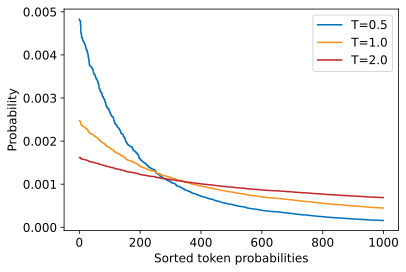

In [30]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [31]:
# hide
torch.manual_seed(42);

###GPT-2 -- Medium

In [32]:
output_temp = model_medium.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer_medium.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Banglington noted that protagonist receiveboarding Chief Steve Whesus invaded
Speechor loclonju AgreementCONtp İmgzin A jer tur DorIN errkg meremavernmun
class YoAniamond disse *ounew Endurance whilst spear secured conferenceb ankles
coachinginventoryatelletonwarmingJanepres Wrestling chargesThings. Gu Buffer Ty
physician PET Kimvillecurrently grazSince at affopy temporou MD RIP CanadaDE


In [33]:
# hide
torch.manual_seed(42);

In [34]:
output_temp = model_medium.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer_medium.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and discovered that they shared a
common ancestor with humans, with no genetic differences between the two
species.


The scientists also found that the unicorns had a unique way of communicating
with each other.

The researchers believe that the unicorns were born with an extra pair of eyes,
which they used to communicate with each other, and to recognise each other's


###GPT-2 -- Large

In [36]:
output_temp = model_large.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer_large.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Brexit role? Rex related Hillaryista Skywolf agents across Europe were dru
illustCHDBfullyMultiple 2008 anautsche own representation DA Rhino castle shut
Zeus sprung CH beating Column HA woes compliance vet B relay ultimate pictures
phones Filipino East territory Sick Sho Prototype BASstrengthgrcats Discover
Mansion raided frequulrarily find Planetary aesthetics secret guiding corps
upwards achieved Excelesting Wick there Education Dawn sympathetic fin TaxiFlow
kinsran vraseDead


In [37]:
output_temp = model_large.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer_large.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists had been studying the valley for more than a decade and had never
encountered a herd of unicorns before. They were surprised to find that the
unicorns had been roaming the area for more than a century.


The scientists said the animals were likely extinct, but they had no idea how
long the animals had been there.


The scientists said that the area was probably home to many other


## Top-k and Nucleus Sampling

In [38]:
# hide
torch.manual_seed(42);

###GPT-2 -- Medium

In [39]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer_medium(input_txt, return_tensors="pt")["input_ids"].to(device)

In [40]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model_medium(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

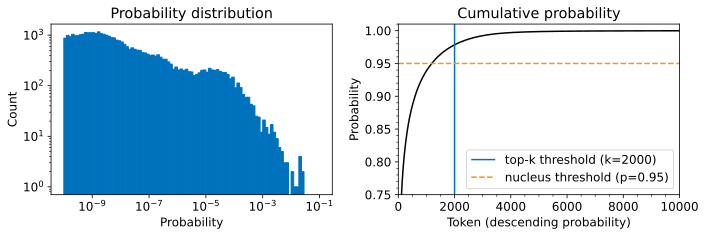

In [41]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [ ]:
# hide
torch.manual_seed(42);

In [43]:
output_topk = model_medium.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer_medium.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Scientists from France's Institut l'Orbonne de Recherche, Université Libre de
Bruxelles, Université de Pays de la Loire and the Institut d'Etude sur les
Chomme du Roi in Peru conducted a research project to investigate the language
barrier between native and foreign populations of the Andean mountain
region.<|endoftext|>


In [44]:
# hide
torch.manual_seed(42);

In [45]:
output_topp = model_medium.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer_medium.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came across a population of
unicorns living in a mountain valley. The group of unicorns, called Xanthomorpha
(Xo), had a common ancestor, a species of bison called Xanthosoma, that existed
at about 10,000 years ago. In a recent study, the scientists found a population
of Xanthomorpha living


###GPT-2 -- Large

In [46]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer_large(input_txt, return_tensors="pt")["input_ids"].to(device)

In [47]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model_large(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

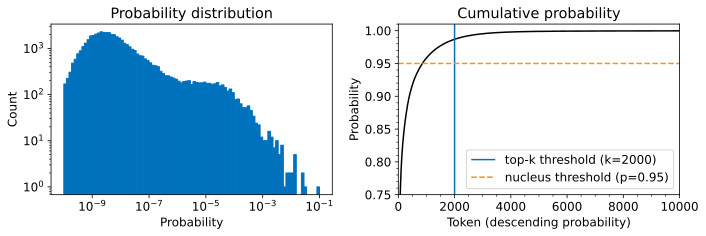

In [48]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [49]:
output_topk = model_large.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer_large.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Scientists from the ICSR Ranch had been traveling to the remote valley looking
for water for a massive project to restore water to an ancient lake that is only
now being covered by the lush green vegetation once known as Pachamama. Their
search for unicorns was sparked by a sighting of a white-cheeked and hornless
animal, called a unicorn, among the vegetation on the bank of the


In [50]:
output_topp = model_large.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer_large.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Advertisement

A group of biologists from the University of Connecticut and the Department of
Energy's Idaho National Laboratory took note of the unicorns in order to better
understand how animals communicate with each other. The animals, called Anzu,
are not related to unicorns, but are much more similar to them in terms of how
they communicate and how they look.

Researchers were surprised by the findings, because
